# iQuHack 2026 - Quantum Entanglement Distillation Game

In this game, you design quantum circuits to distill noisy Bell pairs and claim edges in a network.

**Game Flow**: Register -> Select Starting Node -> Design Circuits -> Claim Edges -> Score Points

In [1]:
from client import GameClient
from visualization import GraphTool
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, qasm3
import json
from numpy import pi
from pathlib import Path


from qiskit.circuit.classical import expr

## Session Management

Save/load your session to avoid re-registering.

In [2]:
SESSION_FILE = Path("session.json")

def save_session(client):
    if client.api_token:
        with open(SESSION_FILE, "w") as f:
            json.dump({"api_token": client.api_token, "player_id": client.player_id, "name": client.name}, f)
        print(f"Session saved.")

def load_session():
    if not SESSION_FILE.exists():
        return None
    with open(SESSION_FILE) as f:
        data = json.load(f)
    client = GameClient(api_token=data.get("api_token"))
    client.player_id = data.get("player_id")
    client.name = data.get("name")
    status = client.get_status()
    if status:
        print(f"Resumed: {client.player_id} | Score: {status.get('score', 0)} | Budget: {status.get('budget', 0)}")
        return client
    return None

In [3]:
# Try to resume existing session
client = load_session()

if not client:
    print("No saved session. Register below.")

Resumed: mk733355 | Score: 0 | Budget: 38


## Step 1: Register

Skip this if you resumed a session above.

In [4]:
if client and client.api_token:
    print(f"Already registered as {client.player_id}")
else:
    client = GameClient()
    
    # CHANGE THESE to your unique values
    PLAYER_ID = "mk733355"
    PLAYER_NAME = "Matvei Karp"
    
    result = client.register(PLAYER_ID, PLAYER_NAME, location=input("remote or in_person: ").strip())
    
    if result.get("ok"):
        print(f"Registered! Token: {client.api_token[:20]}...")
        candidates = result["data"].get("starting_candidates", [])
        print(f"\nStarting candidates ({len(candidates)}):")
        for c in candidates:
            print(f"  - {c['node_id']}: {c['utility_qubits']} qubits, +{c['bonus_bell_pairs']} bonus")
        save_session(client)
    else:
        print(f"Failed: {result.get('error', {}).get('message')}")

Already registered as mk733355


## Step 2: Select Starting Node

In [5]:
status = client.get_status()

if status.get('starting_node'):
    print(f"Starting node: {status['starting_node']}")
    print(f"Budget: {status['budget']} | Score: {status['score']}")
else:
    print("Select a starting node from the candidates shown above.")
    # Uncomment and modify:
    result = client.select_starting_node("Zurich, Switzerland")
    print(result)

Starting node: Zurich, Switzerland
Budget: 38 | Score: 0


## Step 3: Explore the Network

In [6]:
client.print_status()

Player: mk733355 (Matvei Karp)
Score: 0 | Budget: 38 bell pairs
Active: Yes
Starting node: Zurich, Switzerland
Owned: 1 nodes, 0 edges
Claimable edges: 6
  - ['Basel, Switzerland', 'Zurich, Switzerland']: threshold=0.90, difficulty=1
  - ['Bern, Switzerland', 'Zurich, Switzerland']: threshold=0.90, difficulty=1
  - ['Strasbourg, France', 'Zurich, Switzerland']: threshold=0.90, difficulty=1
  ... and 3 more


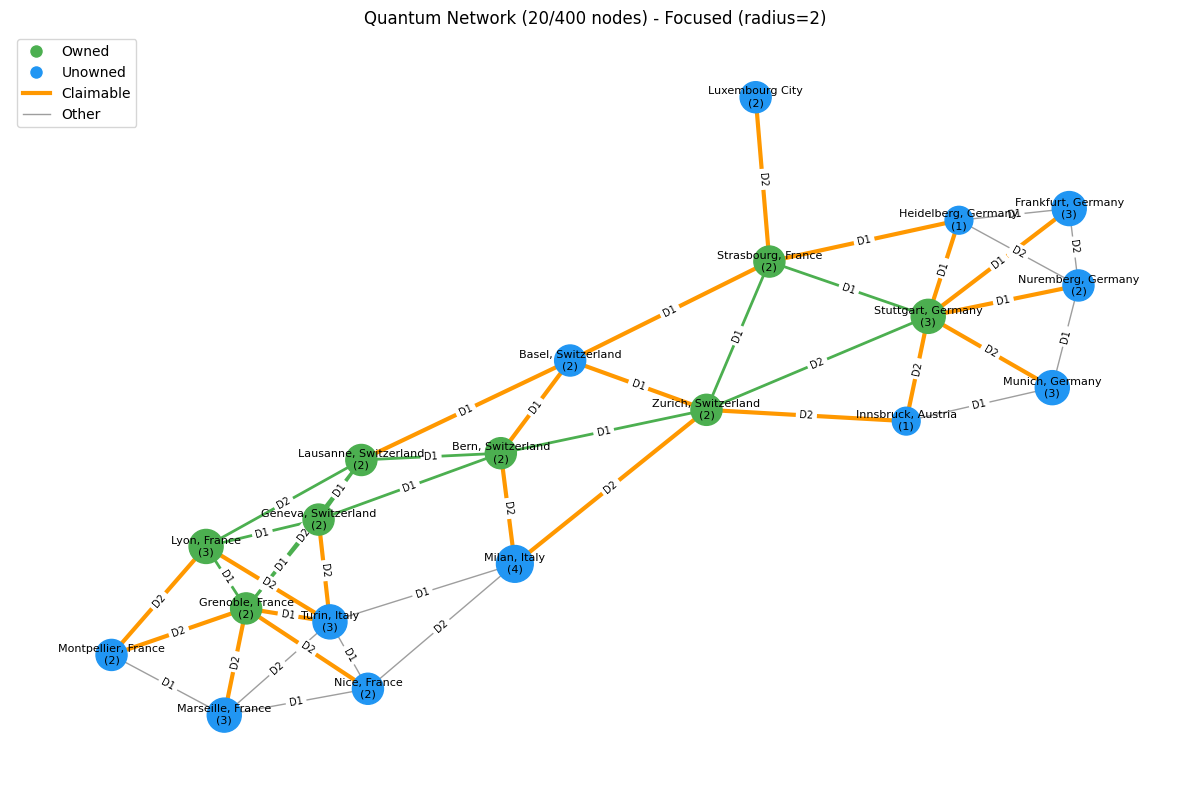

In [76]:
# Visualize the network (focused around your nodes)
viz = GraphTool(client.get_cached_graph())
owned = set(client.get_status().get('owned_nodes', []))
viz.render(owned)

## Step 4: Design a Distillation Circuit

For N Bell pairs, qubits are paired outside-in:
- Pair 0: qubits {0, 2N-1}
- Pair 1: qubits {1, 2N-2}
- ...
- Final pair: qubits {N-1, N}

Design a circuit that improves fidelity through LOCC operations.

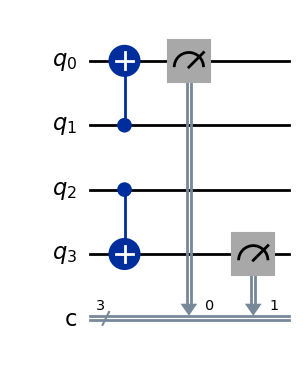

In [29]:
def create_distillation_circuit():
    
    qr = QuantumRegister(4, 'q')  # 4 qubits for 2 Bell pairs
    cr = ClassicalRegister(3, 'c')  # Classical bits for measurements + flag
    qc = QuantumCircuit(qr, cr)

    qc.cx(qr[1], 0)  # Alice's local CNOT
    qc.cx(qr[2], 3)  # Bob's local CNOT

    qc.measure(qr[0], cr[0])
    qc.measure(qr[3], cr[1])

    qc.store(cr[2], expr.bit_xor(cr[0], cr[1]))

    return qc
circuit = create_distillation_circuit()
circuit.draw(output='mpl')

## Step 5: Claim an Edge

In [80]:
# Find claimable edges
claimable = client.get_claimable_edges()
claimable_sorted = sorted(claimable, key=lambda e: (e['difficulty_rating'], e['base_threshold']))

print(f"Claimable edges ({len(claimable)}):")
for edge in claimable_sorted:
    print(f"  {edge['edge_id']} - threshold: {edge['base_threshold']:.3f}, difficulty: {edge['difficulty_rating']}")

Claimable edges (17):
  ['Frankfurt, Germany', 'Stuttgart, Germany'] - threshold: 0.900, difficulty: 1
  ['Grenoble, France', 'Turin, Italy'] - threshold: 0.900, difficulty: 1
  ['Heidelberg, Germany', 'Stuttgart, Germany'] - threshold: 0.900, difficulty: 1
  ['Nuremberg, Germany', 'Stuttgart, Germany'] - threshold: 0.900, difficulty: 1
  ['Heidelberg, Germany', 'Strasbourg, France'] - threshold: 0.900, difficulty: 1
  ['Lyon, France', 'Turin, Italy'] - threshold: 0.900, difficulty: 2
  ['Grenoble, France', 'Marseille, France'] - threshold: 0.900, difficulty: 2
  ['Munich, Germany', 'Stuttgart, Germany'] - threshold: 0.900, difficulty: 2
  ['Bern, Switzerland', 'Milan, Italy'] - threshold: 0.900, difficulty: 2
  ['Milan, Italy', 'Zurich, Switzerland'] - threshold: 0.900, difficulty: 2
  ['Grenoble, France', 'Nice, France'] - threshold: 0.900, difficulty: 2
  ['Innsbruck, Austria', 'Zurich, Switzerland'] - threshold: 0.900, difficulty: 2
  ['Innsbruck, Austria', 'Stuttgart, Germany'] - 

In [81]:
# Claim an edge
if claimable:
    #target = claimable_sorted[0]  # Easiest edge
    target = claimable_sorted[1]
    edge_id = tuple(target['edge_id'])
    
    num_bell_pairs = 2
    circuit = create_distillation_circuit()
    flag_bit = 2  # Classical bit for post-selection (keep when flag=0)
    
    print(f"Claiming {edge_id} (threshold: {target['base_threshold']:.3f})...")
    
    result = client.claim_edge(edge_id, circuit, flag_bit, num_bell_pairs)
    
    if result.get("ok"):
        data = result["data"]
        print(f"Success: {data.get('success')}")
        print(f"Fidelity: {data.get('fidelity', 0):.4f} (threshold: {data.get('threshold', 0):.4f})")
        print(f"Success probability: {data.get('success_probability', 0):.4f}")
    else:
        print(f"Error: {result.get('error', {}).get('message')}")

Claiming ('Grenoble, France', 'Turin, Italy') (threshold: 0.900)...


HTTPError: 400 Client Error: Bad Request for url: https://demo-entanglement-distillation-qfhvrahfcq-uc.a.run.app/v1/claim_edge

## Step 6: Check Progress

In [82]:
client.print_status()

Player: mk733355 (Matvei Karp)
Score: 18 | Budget: 1 bell pairs
Active: Yes
Starting node: Zurich, Switzerland
Owned: 9 nodes, 21 edges
Claimable edges: 17
  - ['Lyon, France', 'Turin, Italy']: threshold=0.90, difficulty=2
  - ['Grenoble, France', 'Marseille, France']: threshold=0.90, difficulty=2
  - ['Munich, Germany', 'Stuttgart, Germany']: threshold=0.90, difficulty=2
  ... and 14 more


In [39]:
# View leaderboard
leaderboard = client.get_leaderboard()["leaderboard"]
print("Leaderboard:")
for i, p in enumerate(leaderboard[:10]):
    print(f"{i+1}. {p.get('player_id', 'Unknown'):20} Score: {p.get('score', 0)}")

Leaderboard:
1. Julio Cesar          Score: 102
2. GiselleRocio         Score: 100
3. diyamagnetism28      Score: 89
4. 121234382            Score: 89
5. bloch_single_run_v8  Score: 85
6. bloch                Score: 84
7. bloch_distiller      Score: 84
8. aquaman              Score: 71
9. test_claude_1523b    Score: 70
10. orion_the_first      Score: 69


## Tips

- **Failed attempts are free** - only successful claims cost bell pairs
- **More bell pairs** can improve fidelity but cost more budget
- **Vertex rewards** are competitive - top players by claim strength earn rewards
- **Budget management** is key - if budget reaches 0, you're eliminated

Good luck!

In [13]:
# Restart game (uncomment to use)
# result = client.restart()
# print(result)